In [1]:
import geopandas as gpd
from osgeo import ogr
import pandas as pd
import tifffile as tiff #needed for the tif data for perry county
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from math import sin, cos, sqrt, atan2, radians
import sys
from shapely.geometry import Polygon, box, Point, LineString, MultiLineString
import pickle
import gurobipy as gp
from gurobipy import GRB
import tifffile as tiff #needed for the tif data for perry county
import xlwt
from xlwt import Workbook
from shapely.ops import snap, split, nearest_points
#from shapely.geometry import MultiPoint, LineString
#from dbfread import DBF
import osmnx as ox
import networkx as nx
import math
import gurobipy as gp
from gurobipy import GRB
import os

In [2]:
os.chdir("/Users/yuelanzhu/Downloads/Research/my code file")

In [3]:
# calculate distance
def haversinedist(lat1, lon1, lat2, lon2):
    R = 6373.0
    
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    distance = R * c
    return distance * 1000 #unit in meters

In [4]:
# read data
def readClusterFile(fileID):
    file = np.genfromtxt(fileID, delimiter=",", skip_header = 1)
    file = file[:,1:]
    return file
clusterfile = 'Centralized_elevcluster' + str(1) + '.csv'

In [5]:
building_coords = readClusterFile(clusterfile)

In [6]:
#convert data to dataframe
df = pd.DataFrame(building_coords,
                  columns = ['longitude','latitude','elevation'])

In [7]:
#check # of null
df.isnull().sum(axis=0).sort_values(ascending=False)/float(len(building_coords))

longitude    0.0
latitude     0.0
elevation    0.0
dtype: float64

In [8]:
# cluster, n_clusters is from table 2 in paper draft, using ward-tree
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=100, affinity='euclidean', linkage='ward')
cluster.fit_predict(building_coords[:,1:2])

array([46, 94, 60, ..., 92, 15, 64])

In [9]:
# add cluster to dataframe
df['cluster.labels_'] = cluster.labels_.tolist()

In [10]:
# select highest and lowest nodes in cluster
tank = df.loc[df.groupby(['cluster.labels_'])['elevation'].idxmax()].reset_index(drop=True)
trem = df.loc[df.groupby(['cluster.labels_'])['elevation'].idxmin()].reset_index(drop=True)

In [11]:
# creat MST

graph = []
mstree = []
def createMSTnx(dataframe):
    #only takes longitude and latitude from the cluster data, note we also have elevation and stuff there too
    #coordinates = twoDcluster
    for k in range(10):
        cluster = dataframe[dataframe['cluster.labels_'] == k]
        cluster = cluster[['longitude','latitude']]
        latlon = cluster.to_numpy()
        nrows, ncols = latlon.shape
        #creates graph
        graph.append(nx.Graph())
        weights = []
        #distance in km as weight between each point in the graph
        for i in range(nrows):
            graph[k].add_node(i,pos=(latlon[i,0],latlon[i,1]))
            for j in range(i+1,nrows):
                dist = haversinedist(latlon[i,1], latlon[i,0], latlon[j,1], latlon[j,0])
                weights.append(dist)
                graph[k].add_edge(i,j, weight = dist)
        #creates MST
        mstree.append(nx.minimum_spanning_tree(graph[k]))
    return mstree, graph

In [12]:
createMSTnx(df)

([<networkx.classes.graph.Graph at 0x7ff1d4c95e80>,
  <networkx.classes.graph.Graph at 0x7ff1d4cbc310>])

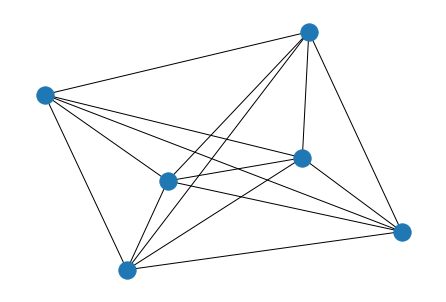

In [13]:
# draw a simulation of graph

nx.draw(graph[9])

In [14]:
m = gp.Model('pipe and pump distribution')
m.Params.timeLimit = 12000

Set parameter Username
Academic license - for non-commercial use only - expires 2022-09-18
Set parameter TimeLimit to value 12000


In [15]:
# pipe parameters
pipesize = [0.05, 0.06, 0.08, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6] #m
pipesize_str, pipecost = gp.multidict({'0.05': 8.7, '0.06': 9.5, '0.08': 11, \
                                                   '0.1': 12.6, '0.15': 43.5,'0.2': 141, '0.25': 151, '0.3': 161, '0.35':230, '0.4': 246, '0.45':262, 
                                                   '0.5':292, '0.6':315})

In [16]:
# pump parameters
# power in kW, default value from Matlab document
pumptype = [2, 5, 800]
# efficiency corresponding to power
pump_eff = [0.8, 0.9, 0.9]

# find label of tank node in cluster
tank_lon = str(tank[tank['cluster.labels_'] == 9][['longitude']].iat[0,0])
tank_lat = str(tank[tank['cluster.labels_'] == 9][['latitude']].iat[0,0])
for i in mstree[9].nodes():
    if str(mstree[9].nodes[i]['pos'][0]) == tank_lon and str(mstree[9].nodes[i]['pos'][1]) == tank_lat:
        tank_node = i

In [17]:
# set variables

# binary variable indicating if at link ij pipe of diameter k is implemented
d = m.addVars(mstree[9].edges(), pipesize, vtype = GRB.BINARY, name = "DIAMETER")

# continuous variable indicating flow through link ij.
q = m.addVars(mstree[9].edges(),lb = 0, vtype = GRB.CONTINUOUS, name = "FLOW")
qhelper =  m.addVars(mstree[9].edges(), vtype = GRB.CONTINUOUS, name = "qhelper")
#qdiv = m.addVars(mstree[9].edges(),lb = 0, vtype = GRB.CONTINUOUS, name = "qdiv")

# continuous variable indicating inflow and outflow for each node
#qin = m.addVars(mstree[9].nodes(),lb = 0, vtype = GRB.CONTINUOUS, name = "INFLOW")
#qout = m.addVars(mstree[9].nodes(),lb = 0, vtype = GRB.CONTINUOUS, name = "OUTFLOW")

# binary variable indicating if at link ij the pump of type m is implemented.
p = m.addVars(mstree[9].edges(), vtype = GRB.BINARY, name = "PUMP")

#continuous variable representing the pressure injected by the pump at link ij.
pr = m.addVars(mstree[9].edges(),lb = 0, vtype = GRB.CONTINUOUS, name = "PRESSURE BY PUMP")

#continuous variable representing the head pressure at node i
P = m.addVars(mstree[9].nodes(),lb = 0, vtype = GRB.CONTINUOUS, name = "HEAD PRESSURE")

#pipe elevations at node i 
e = m.addVars(mstree[9].nodes(), vtype = GRB.CONTINUOUS, name = 'In Node Elevation')

# area of section of pipe of diameter dt
#A = m.addVars(mstree[9].edges(),lb = 0, vtype = GRB.CONTINUOUS, name = "pipe area")

# head pressure loss for edge n
loss = m.addVars(mstree[9].edges(),lb = 0, vtype = GRB.CONTINUOUS, name = "loss")

# just a calculated item used to avoid bug
#item = m.addVars(mstree[9].edges(),lb = 0, vtype = GRB.CONTINUOUS, name = "item")

In [18]:
#node elevation excavation in meters
#upper bound is arbritrary maximum depth assuming 1 foot or 0.3048 meters of cover beneath the surface is needed for the pipes
#a lower bound variable is created but not used. In future models might need to implement that depending on the site (digging too deep for excavation is not feasible for many projects)
cluster9 = df[df['cluster.labels_'] == 9]
cluster9_elv = cluster9[['elevation']]
elevation_ub = dict()
elevation_lb = dict()
for i in range(mstree[9].number_of_nodes()):
    elevation_ub[i] = cluster9_elv.iloc[[i]] - 0.3048
    elevation_lb[i] = cluster9_elv.iloc[[i]] - 30

In [19]:
cluster9_elv

,elevation
310,85.771072
341,86.083984
342,86.830093
465,89.033676
1042,81.478424
1043,81.077316


In [20]:
innode = {}
outnode = {}
for i,j in mstree[9].edges():
    if len(nx.shortest_path(mstree[9],source=tank_node, target=i)) > len(nx.shortest_path(mstree[9],source=tank_node, target=j)):
        # if node j is nearer to tank
        innode.setdefault(i, [])
        innode[i].append(j)
        outnode.setdefault(j, [])
        outnode[j].append(i)
    else:
        # if node i is nearer to tank
        innode.setdefault(j, [])
        innode[j].append(i)
        outnode.setdefault(i, [])
        outnode[i].append(j)

In [21]:
outnode

{1: [0, 2], 3: [1, 4], 4: [5]}

In [22]:
for i in mstree[9].nodes():
    innode.setdefault(i,[])
    outnode.setdefault(i, [])

dist1 = []
dist2 = []
for i,j in mstree[9].edges():
    # split graph at tank node
    if i < tank_node:
        if len(nx.shortest_path(mstree[9],source=tank_node, target=i)) < len(nx.shortest_path(mstree[9],source=tank_node, target=j)):
        # if node i is nearer to tank
            dist = len(nx.shortest_path(mstree[9],source=tank_node, target=j))
            dist1.append(dist)         
        else: # if node j is nearer to tank
            dist = len(nx.shortest_path(mstree[9],source=tank_node, target=i))
            dist1.append(dist) 
                      
    else:
        if len(nx.shortest_path(mstree[9],source=tank_node, target=i)) < len(nx.shortest_path(mstree[9],source=tank_node, target=j)):
            dist = len(nx.shortest_path(mstree[9],source=tank_node, target=j))
            dist2.append(dist)
        else:
            dist = len(nx.shortest_path(mstree[9],source=tank_node, target=i))
            dist2.append(dist)

def d(d):
    d = len(nx.shortest_path(mstree[9],source=tank_node, target=d))
    return d

In [23]:
#create flow direction dict
flow_dir = {}
for i,j in mstree[9].edges():
    if len(nx.shortest_path(mstree[9],source=tank_node, target=i)) < len(nx.shortest_path(mstree[9],source=tank_node, target=j)):
        # if node i is nearer to tank
        flow_dir[i,j]=(i,j)
    if len(nx.shortest_path(mstree[9],source=tank_node, target=i)) > len(nx.shortest_path(mstree[9],source=tank_node, target=j)):
        # if node j is nearer to tank
        flow_dir[i,j]=(j,i) 

# water demand, tank is 3
for i,j in flow_dir:
    m.addConstr(q[i,j] >= 0.9464,"water demand at terminal node" + str([i,j]))
    start = flow_dir[i,j][0]
    end = flow_dir[i,j][1]
    m.addConstr(qin[end] == qin[end] + q[i,j],"qin" + str([end]))
    m.addConstr(qout[start] == qout[start] + q[i,j],"qout" + str([i,j]))

#for i in qin:
    #m.addConstr(qin[i] == qout[i] + 0.9464,"water demand" + str(i))
    
m.addConstr(qin[tank_node] == 0.9464 * mstree[9].number_of_nodes(), "water balance at source node")

#m.addConstr(qout[0]==0)
#m.addConstr(qout[2]==0)
#m.addConstr(qout[5]==0)
#m.addConstrs((q.sum('*',i) == q.sum(i,'*')+inflow(i) for i in nodes),"flow")

#keep this 

In [24]:
for i,j in flow_dir:
    start = flow_dir[i,j][0]
    end = flow_dir[i,j][1]
    m.addConstr(q[i,j] == 0.9464*3600*24*(len(outnode[end])+1), "water demand balance") #250gpd to m3/s

#add manually
m.addConstr(q[0,1]==0.9464)
m.addConstr(q[1,2]==0.9464)
m.addConstr(q[4,5]==0.9464)
m.addConstr(q[1,3]==3*0.9464)
m.addConstr(q[3,4]==2*0.9464)

m.addConstr(q[3,4]==q[4,5]+0.9464)
m.addConstr(q[1,3]==q[0,1]+q[1,2]+0.9464)
m.addConstr(q[0,1]>=0.9464)
m.addConstr(q[1,2]>=0.9464)
m.addConstr(q[4,5]>=0.9464)

for i,j in mstree[9].edges():
    if i < tank_node:
        if len(nx.shortest_path(mstree[9],source=tank_node, target=j))==max(dist1):
            m.addConstr(q[i,j]>=0.9464, "water demand at leave nodes")
        if len(nx.shortest_path(mstree[9],source=tank_node, target=i))==max(dist1):
            m.addConstr(q[i,j]>=0.9464, "water demand at leave nodes")
        else: 
            m.addConstr(sum(q[i,m] for m in innode[i] if d(i)>d(m))==
                        sum(q[i,k] for k in outnode[i] if d(i)<d(k) and k>i) #q[1,0]
                        +sum(q[k,i] for k in outnode[i] if d(i)>d(k)))
                        
                                
    else:
        if len(nx.shortest_path(mstree[9],source=tank_node, target=j))==max(dist2):
            m.addConstr(q[i,j]>=0.9464, "water demand at leave nodes")
        if len(nx.shortest_path(mstree[9],source=tank_node, target=i))==max(dist2):
            m.addConstr(q[i,j]>=0.9464, "water demand at leave nodes")
        

for i in qin:
    n = []
    n.append(
        len(nx.shortest_path(mstree[9],source=tank_node, target=i)) > 
        len(nx.shortest_path(mstree[9],source=tank_node, target=j)))
    m.addConstr(sum(q[i,j] for j in n
    
    m.addConstr(sum(q[i,j] for i,j in mstree[9].edges() and 
                    len(nx.shortest_path(mstree[9],source=tank_node, target=i)) > 
                    len(nx.shortest_path(mstree[9],source=tank_node, target=j)))
                == sum(q[i,j] for i,j in mstree[9].edges() and 
                    len(nx.shortest_path(mstree[9],source=tank_node, target=i)) <
                    len(nx.shortest_path(mstree[9],source=tank_node, target=j)))
                + 0.9464, "water demand")

In [25]:
# add constraints

for i in mstree[9].nodes():
    #qin− qout = daily water demand for each node
    #m.addConstr(qin[i]-qout[i] >= 0.9464, "water demand")# assume 250 gpd, covert it to 0.9464 m3/h
    m.addConstr(P[i] >= 68.9476, "Min head pressure") #10 psi, covert it to kpa
    m.addConstr(P[i] <= 551.581, "Max head pressure") #80 psi, covert it to kpa  
    
    # pipe elevation must be betwenn lb and ub
    m.addConstr(e[i] >= float(str(elevation_lb[i])[20:]), "PIPE ELV LB")
    #m.addConstr(e[i] <= float(str(elevation_ub[i])[20:]), "PIPE ELV UB")

for i,j in mstree[9].edges():
    
    if len(nx.shortest_path(mstree[9],source=tank_node, target=i)) < len(nx.shortest_path(mstree[9],source=tank_node, target=j)):
        # if node i is nearer to tank
        # define q[i,j] based on qin and qout
        linkqin = []
        keys = [*range(0, len(qin), 1)]
        values = [0]*len(qin)
        for a, b in mstree[9].edges():
            if a==i:
                linkqin.append(qin[b]) 
                values[a]=sum(linkqin)
        m.addConstr(qout[i] == values[i])
        m.addConstr(q[i,j] == qout[i])
        qoutsum = dict(zip(keys, values))

In [26]:
for i,j in mstree[9].edges():
    
    #if len(nx.shortest_path(mstree[9],source=tank_node, target=i)) < len(nx.shortest_path(mstree[9],source=tank_node, target=j)):
        # if node i is nearer to tank        
        # Pipe slope must be greater than 1%, or a pump station is used
        #m.addConstr(
            #((1-arc_pumps.sum(i, j, '*'))*0.01 <= (e[i] - e[j]) / mstree[9][i][j]["weight"]), 
            #("slope max" + '[' + str(i) + ',' + str(j)+ ']'))

    #if len(nx.shortest_path(mstree[9],source=tank_node, target=i)) > len(nx.shortest_path(mstree[9],source=tank_node, target=j)):
        # if node j is nearer to tank       
        # Pipe slope must be greater than 1%, or a pump station is used
        #m.addConstr(
            #((1-arc_pumps.sum(i, j, '*'))*0.01 <= (e[j] - e[i]) / mstree[9][i][j]["weight"]), #dict
            #("slope max" + '[' + str(i) + ',' + str(j)+ ']'))
    
    #only one pipe per edge
    m.addConstr((d.sum(i, j, '*') == 1.0), "single size chosen")
    #only one pump per edge
    #m.addConstr((p.sum(i, j, '*') <= 1.0), "single type chosen")
    
    # Velocity must be between 0.6 and 3 m/s to 30
    #m.addConstr((
    #q[i,j] <= ((3.14/8)*gp.quicksum(d[i,j,k]*k**2 for k in pipesize)) * 10), "Velocity Max Constr"+ str([i,j]))
    m.addConstr((
    q[i,j] >= ((3.14/8)*gp.quicksum(d[i,j,k]*k**2 for k in pipesize)) * 0.6), "Velocity Min Constr" + str([i,j]))  
    

 # injected pressure pr[i,j] must be less than the capacity of pump.
    m.addConstr((
        pr[i,j]*q[i,j]*(9.80665*1000) <= 
        gp.quicksum(arc_pumps[i,j,k]*k*pump_eff[pumptype.index(k)] for k in pumptype)), 
        "pressure by pump less than the capacity")
# conservation of Head at edge n, use Hazen Williams equation
    m.addConstr(A[i,j] == 3.14/4*gp.quicksum(arc_sizes[i,j,k]*k for k in pipesize), "pipe area")
    f = 0.3
    m.addConstr(item[i,j]*2*9.80665*A[i,j]==q[i,j]*q[i,j], "item")
    m.addConstr(loss[i,j] == (gp.quicksum(arc_sizes[i,j,k]/k for k in pipesize))*f*mstree[9][i][j]["weight"]*item[i,j], 
                "loss")#(q[i,j])**2/(2*9.80665*A[i,j]))
    m.addConstr((H[i]-H[j]==loss[i,j]-pr[i,j]),"conservation of Head")
    
    #loose inequa
    #remove pump cons

## q as variable

for i,j in mstree[9].edges():
    #q^1.85
    m.addGenConstrPow(q[i,j],qhelper[i,j],1.85)
    # q divided
    #m.addConstr(q[i,j]*qdiv[i,j] == 1)
    #Hazen Williams equation, C=150, B=151
    #m.addConstr(loss[i,j] == 
                #(151/150)**1.85*qhelper[i,j]*gp.quicksum(d[i,j,k]/k**(1.85-2.63) for k in pipesize)
               #, "Hydro loss")
    m.addConstr(loss[i,j] == 
                10.67*qhelper[i,j]/(150**1.825)*gp.quicksum(d[i,j,k]/k**4.8704 for k in pipesize)
               , "Hydro loss")
    #m.addConstr(loss[i,j] == 
                    #mstree[9][i][j]["weight"]*151/151**1.852*qhelper[i,j]*gp.quicksum(d[i,j,k]/k**4.8704 for k in pipesize)
               #, "Hydro loss")
    # injected pressure pr[i,j] must be less than the capacity of pump.
    m.addConstr(pr[i,j]<=p[i,j]*10**6)
    #m.addConstr((
        #q[i,j]*pr[i,j]*(9.80665*1000) <= 
        #gp.quicksum(arc_pumps[i,j,k]*k*pump_eff[pumptype.index(k)] for k in pumptype)), 
        #"pressure by pump less than the capacity")
    if len(nx.shortest_path(mstree[9],source=tank_node, target=i)) < len(nx.shortest_path(mstree[9],source=tank_node, target=j)):
        # if node i is nearer to tank        
        m.addConstr(P[j] == P[i] -mstree[9][i][j]["weight"]*loss[i,j] + e[i] - e[j] + pr[i,j], "Energy balance")
    if len(nx.shortest_path(mstree[9],source=tank_node, target=i)) > len(nx.shortest_path(mstree[9],source=tank_node, target=j)):
        # if node j is nearer to tank        
        m.addConstr(P[i] == P[j] -mstree[9][i][j]["weight"]*loss[i,j] + e[j] - e[i] + pr[i,j], "Energy balance")

In [27]:
# q solution
qsol = {}
qsol[0,1] = 0.9464*3600*24
qsol[1,2] = 0.9464*3600*24
qsol[4,5] = 0.9464*3600*24
qsol[1,3] = 0.9464*3600*24*3
qsol[3,4] = 0.9464*3600*24*2

In [28]:
qsol

{(0, 1): 81768.95999999999,
 (1, 2): 81768.95999999999,
 (4, 5): 81768.95999999999,
 (1, 3): 245306.87999999998,
 (3, 4): 163537.91999999998}

In [29]:
## q predetermined
for i,j in mstree[9].edges():
    # injected pressure pr[i,j] 
    m.addConstr(pr[i,j]<=p[i,j]*10**6)
    #Hazen Williams equation, C=150, P503
    m.addConstr(loss[i,j] == 
                10.67*qsol[i,j]**1.85/(150**1.825)*gp.quicksum(d[i,j,k]/k**4.8704 for k in pipesize)
               , "Hydro loss")
    if len(nx.shortest_path(mstree[9],source=tank_node, target=i)) < len(nx.shortest_path(mstree[9],source=tank_node, target=j)):
        # if node i is nearer to tank        
        m.addConstr(P[j] == P[i] -mstree[9][i][j]["weight"]*loss[i,j] + e[i] - e[j] + pr[i,j], "Energy balance")
    if len(nx.shortest_path(mstree[9],source=tank_node, target=i)) > len(nx.shortest_path(mstree[9],source=tank_node, target=j)):
        # if node j is nearer to tank        
        m.addConstr(P[i] == P[j] -mstree[9][i][j]["weight"]*loss[i,j] + e[j] - e[i] + pr[i,j], "Energy balance")

# add constraints

for i,j in mstree[9].edges():
    
    if len(nx.shortest_path(mstree[9],source=tank_node, target=i)) > len(nx.shortest_path(mstree[9],source=tank_node, target=j)):
        # if node j is nearer to tank
        # define q[i,j] based on qin and qout
        linkqin = []
        for a, b in mstree[9].edges():
            if b==j:
                linkqin.append(qin[a])
        m.addConstr(qout[j] == qoutsum[j]+sum(linkqin))
        m.addConstr(q[i,j] == qout[j])

In [30]:
excavation = 25
bedding_cost_sq_ft = 6
capital_cost_pump_station = 166000
ps_flow_cost = 0.19
ps_OM_cost = 175950
#hometreatment = 5500
#water_spec_weight = 9.8
#fixed_treatment_cost = 10000
#kwh_hour = 0.114
#collection_om = 209

In [31]:
# set obective function

# pipe cost #keep this
obj1 = gp.quicksum(mstree[9][i][j]["weight"] * gp.quicksum(pipecost[str(k)] * d[i, j, k] 
                                                           for k in pipesize) for i,j in mstree[9].edges())

# Capital cost of pump stations
obj2 = gp.quicksum(p.sum(i, j) * capital_cost_pump_station for i,j in mstree[9].edges())

#Operation and maintenance costs
obj3 = gp.quicksum(p.sum(i, j)*ps_OM_cost for i, j in mstree[9].edges())

# cost of exaction and bedding for all installed collection systems pipes
#obj4 = ((1 + gp.quicksum(arc_sizes[i,j,k]*k for k in pipesize)*0.01) * mstree[9][i][j]["weight"]*3.3#covert m to ft 
        #* bedding_cost_sq_ft + excavation * \
        #(1 + gp.quicksum(arc_sizes[i,j,k]*k for k in pipesize)*0.01) * mstree[9][i][j]["weight"] * 0.5
        #* ((elevation_ub[i] - e[i]) + (elevation_ub[j] - e[j]))
        #for i, j in mstree[9].edges())

obj = obj1 + obj2 + obj3

In [32]:
m.setObjective(obj, GRB.MINIMIZE)

In [33]:
#m.params.NonConvex = 2

In [34]:
m.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 48 rows, 102 columns and 268 nonzeros
Model fingerprint: 0x3374ca84
Variable types: 32 continuous, 70 integer (70 binary)
Coefficient statistics:
  Matrix range     [6e-04, 2e+13]
  Objective range  [3e+02, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+05]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 34 rows and 28 columns
Presolve time: 0.00s
Presolved: 14 rows, 74 columns, 148 nonzeros
Variable types: 7 continuous, 67 integer (67 binary)

Root relaxation: objective 1.723244e+04, 29 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 17232.4449    0    4          - 172

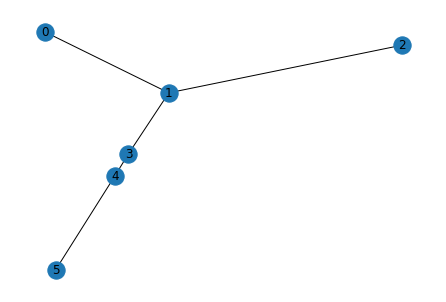

In [35]:
# draw a simulation of MST
nx.draw(mstree[9],with_labels = True)

In [36]:
status = m.status
if status == GRB.Status.OPTIMAL:
    for v in m.getVars():
        print('%s %g' % (v.varName, v.x))
    print('Obj: %g' % m.objVal)
       
elif status == GRB.Status.INFEASIBLE:
    print('Optimization was stopped with status %d' % status)
    # do IIS
    m.computeIIS()
    m.write("m.ilp")
    gp.read("m.ilp")
    for c in m.getConstrs():
        if c.IISConstr:
            print('%s' % c.constrName)

DIAMETER[0,1,0.05] 1
DIAMETER[0,1,0.06] -0
DIAMETER[0,1,0.08] -0
DIAMETER[0,1,0.1] -0
DIAMETER[0,1,0.15] -0
DIAMETER[0,1,0.2] -0
DIAMETER[0,1,0.25] -0
DIAMETER[0,1,0.3] -0
DIAMETER[0,1,0.35] -0
DIAMETER[0,1,0.4] -0
DIAMETER[0,1,0.45] -0
DIAMETER[0,1,0.5] -0
DIAMETER[0,1,0.6] -0
DIAMETER[1,2,0.05] 1
DIAMETER[1,2,0.06] -0
DIAMETER[1,2,0.08] -0
DIAMETER[1,2,0.1] -0
DIAMETER[1,2,0.15] -0
DIAMETER[1,2,0.2] -0
DIAMETER[1,2,0.25] -0
DIAMETER[1,2,0.3] -0
DIAMETER[1,2,0.35] -0
DIAMETER[1,2,0.4] -0
DIAMETER[1,2,0.45] -0
DIAMETER[1,2,0.5] -0
DIAMETER[1,2,0.6] -0
DIAMETER[1,3,0.05] 1
DIAMETER[1,3,0.06] -0
DIAMETER[1,3,0.08] -0
DIAMETER[1,3,0.1] -0
DIAMETER[1,3,0.15] -0
DIAMETER[1,3,0.2] -0
DIAMETER[1,3,0.25] -0
DIAMETER[1,3,0.3] -0
DIAMETER[1,3,0.35] -0
DIAMETER[1,3,0.4] -0
DIAMETER[1,3,0.45] -0
DIAMETER[1,3,0.5] -0
DIAMETER[1,3,0.6] -0
DIAMETER[3,4,0.05] -0
DIAMETER[3,4,0.06] 0
DIAMETER[3,4,0.08] 1
DIAMETER[3,4,0.1] -0
DIAMETER[3,4,0.15] -0
DIAMETER[3,4,0.2] -0
DIAMETER[3,4,0.25] -0
DIAMETER[3,4,

In [37]:
mstree[9][1][3]#["weight"]*loss[0,1]

{'weight': 139.08777358090938}

In [38]:
for i,j in mstree[9].edges():
    #Hazen Williams equation, C=150, P503
    m.addConstr(loss[i,j] == 
                10.67*qsol[i,j]**1.85/(150**1.825)*gp.quicksum(d[i,j,k]/k**4.8704 for k in pipesize)
               , "Hydro loss")
    if len(nx.shortest_path(mstree[9],source=tank_node, target=i)) < len(nx.shortest_path(mstree[9],source=tank_node, target=j)):
        # if node i is nearer to tank        
        m.addConstr(P[j] == P[i] -mstree[9][i][j]["weight"]*loss[i,j] + e[i] - e[j] + pr[i,j], "Energy balance")
    if len(nx.shortest_path(mstree[9],source=tank_node, target=i)) > len(nx.shortest_path(mstree[9],source=tank_node, target=j)):
        # if node j is nearer to tank        
        m.addConstr(P[i] == P[j] -mstree[9][i][j]["weight"]*loss[i,j] + e[j] - e[i] + pr[i,j], "Energy balance")

In [39]:
m.update()
copy = m.copy()

if m.status == GRB.INFEASIBLE:
    vars = copy.getVars()
    ubpen = [1.0]*copy.numVars
    copy.feasRelax(1, False, vars, None, ubpen, None, None)
    copy.optimize()

import wntr

# Create a water network model
inp_file = 'networks/Net3.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, node_attribute='elevation', node_colorbar_label='Elevation (m)')

# Simulate hydraulics
wn.options.hydraulic.demand_model = 'DD'
sim = wntr.sim.EpanetSimulator(wn)
wn.options.hydraulic.required_pressure = 21.097 # 30 psi = 21.097 m
wn.options.hydraulic.minimum_pressure  = 3.516 # 5 psi = 3.516 m
wn.options.hydraulic.minimum_pressure = 0.55
junction = wn.get_node('121')
junction.required_pressure = 14.065 # 20 psi = 14.065 m
junction.minimum_pressure = 0.352 # 0.5 psi = 0.352 m
junction.pressure_exponent = 0.4
results = sim.run_sim()

# Plot results on the network
pressure_at_5hr = results.node['pressure'].loc[5*3600, :]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_5hr, node_size=30, 
                        title='Pressure at 5 hours')

wn.options.quality.parameter = 'AGE'
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()
water_age = results.node['quality']/3600 # convert seconds to hours
anim = wntr.graphics.network_animation(wn, node_attribute=water_age, node_range=[0,24])

pressure_at_node123 = results.node['pressure'].loc[:,'123']
ax = pressure_at_node123.plot()
text = ax.set_xlabel("Time (s)")
text = ax.set_ylabel("Pressure (m)")


# Create a water network model and simulate under nominal conditions
inp_file = 'networks/Net3.inp'
wn = wntr.network.WaterNetworkModel(inp_file)
wn.options.hydraulic.demand_model = 'PDD'

# Add fire demand and simulate
fire_flow_demand = 0.252 # 4000 gal/min = 0.252 m3/s
fire_start = 10*3600
fire_end = 36*3600
node = wn.get_node('197')
node.add_fire_fighting_demand(wn, fire_flow_demand, fire_start, fire_end)
sim = wntr.sim.WNTRSimulator(wn)
fire_results = sim.run_sim()

# Reset initial values and simulate hydraulics under nominal conditions
wn.reset_initial_values()
node.remove_fire_fighting_demand(wn)
sim = wntr.sim.WNTRSimulator(wn)
results = sim.run_sim()

# Plot resulting differences on the network
pressure_at_24hr = results.node['pressure'].loc[24*3600, :]
fire_pressure_at_24hr = fire_results.node['pressure'].loc[24*3600, :]
pressure_difference = fire_pressure_at_24hr - pressure_at_24hr
wntr.graphics.plot_network(wn, node_attribute=pressure_difference, node_size=30, 
                        title='Nominal - Fire Fighting \npressure difference at 24 hours')


>>> wn = wntr.network.WaterNetworkModel()
>>> wn.add_pattern('pat1', [1])
>>> wn.add_pattern('pat2', [1,2,3,4,5,6,7,8,9,10])
>>> wn.add_junction('node1', base_demand=0.01, demand_pattern='pat1', elevation=100,
...     coordinates=(1,2))
>>> wn.add_junction('node2', base_demand=0.02, demand_pattern='pat2', elevation=50,
...     coordinates=(1,3))
>>> wn.add_pipe('pipe1', 'node1', 'node2', length=304.8, diameter=0.3048,
...    roughness=100, minor_loss=0.0, initial_status='OPEN')
>>> wn.add_reservoir('res', base_head=125, head_pattern='pat1', coordinates=(0,2))
>>> wn.add_pipe('pipe2', 'node1', 'res', length=100, diameter=0.3048, roughness=100,
...     minor_loss=0.0, initial_status='OPEN')
>>> ax = wntr.graphics.plot_network(wn)